In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=F05XORVR51J99MYRZD8PWAF1HNAS9H
%env CLEARML_API_SECRET_KEY=v8YQIVFK4LnlZf0R6oac1TpAcvse9Q2wy67JGB6gEe7EPlEHYPzX9lvxvnSkfTrBuhQ

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=F05XORVR51J99MYRZD8PWAF1HNAS9H
env: CLEARML_API_SECRET_KEY=v8YQIVFK4LnlZf0R6oac1TpAcvse9Q2wy67JGB6gEe7EPlEHYPzX9lvxvnSkfTrBuhQ


In [2]:
# ======================================================
# 步骤 1: 初始化与高级配置 (Advanced Configuration)
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from clearml import Task, Dataset  # [新增] 引入 Dataset 类

# ---- 1. 定义高级嵌套配置 ----
# 这里我们将参数分类，并增加控制开关
config_data = {
    # 数据处理参数
    'dataset_params': {
        'dataset_url': 'adults.csv',   # 原始数据路径
        'test_size': 0.2,              # 测试集比例
        'random_state': 42,            # 随机种子
        'stratify': True               # 是否分层采样
    },
    # 流程控制开关 (Flow Control Flags)
    # 这对应文档中提到的“通过配置控制代码执行路径”
    'flags': {
        'perform_eda': True,           # 是否执行可视化分析
        'drop_duplicates': True,       # 是否删除重复行
        'use_advanced_features': True, # 是否使用高级特征工程(如合并婚姻状况)
        'upload_as_dataset': True      # 是否作为 ClearML Dataset 版本发布
    }
}

# ---- 2. 初始化 ClearML 任务 ----
# 注意：任务类型设为 data_processing
task = Task.init(
    project_name="Adult-Income-Classification", 
    task_name="Data_Preparation_v1",           # 明确这是预处理任务
    task_type=Task.TaskTypes.data_processing,  # 标记任务类型
    tags=["Data_Prep", "Feature_Engineering"]
)

# ---- 3. 连接配置 ----
# ClearML 会在网页端显示这个嵌套结构，你可以随时修改 flags 来控制流程
task.connect(config_data)

print(f"🚀 预处理任务初始化完成。")
print(f"🔧 当前配置开关: {config_data['flags']}")

ClearML Task: created new task id=6e616d219adb4f7ba228b2c41dc98d3d
2025-12-26 18:30:38,154 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/5f6e8f0e87604053bec910beb345b850/experiments/6e616d219adb4f7ba228b2c41dc98d3d/output/log
🚀 预处理任务初始化完成。
🔧 当前配置开关: {'perform_eda': True, 'drop_duplicates': True, 'use_advanced_features': True, 'upload_as_dataset': True}


In [3]:
# ======================================================
# 步骤 2: 数据加载 (Data Loading) - 修正版
# ======================================================

# 从配置中读取路径
file_path = config_data['dataset_params']['dataset_url']

try:
    df = pd.read_csv(file_path)
    
    # [核心修正] 去除列名两端的空格 (非常关键!)
    # 很多 CSV 文件的列名是 " age", " income" 这种带空格的格式
    df.columns = df.columns.str.strip()
    
    print(f"✅ 成功加载数据: {file_path}")
    print(f"   数据形状: {df.shape}")
    print(f"   🔍 当前所有列名: {df.columns.tolist()}") # 打印出来检查
    
    # [必须] 将原始数据作为 Artifact 上传
    task.upload_artifact(name='Raw_CSV', artifact_object=file_path)
    
except FileNotFoundError:
    print(f"❌ 找不到文件: {file_path}，请确保文件在当前目录下。")

# 预览
df.head()

✅ 成功加载数据: adults.csv
   数据形状: (48842, 15)
   🔍 当前所有列名: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'class']


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


📊 [Config Check] perform_eda=True，正在执行可视化分析...
✅ 锁定目标列: 'class'
ℹ️ 已将列 'class' 重命名为 'target'。


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8320\1202131751.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\clearml\utilities\plotlympl\renderer.py:209: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



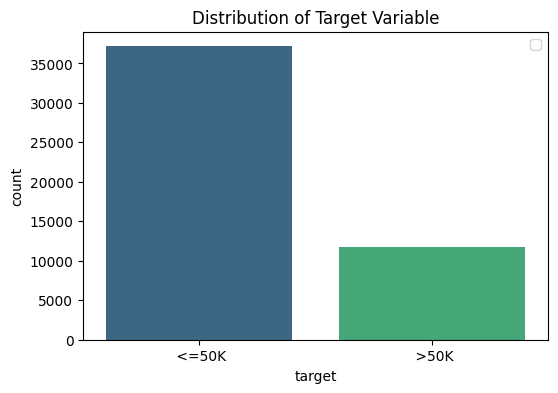

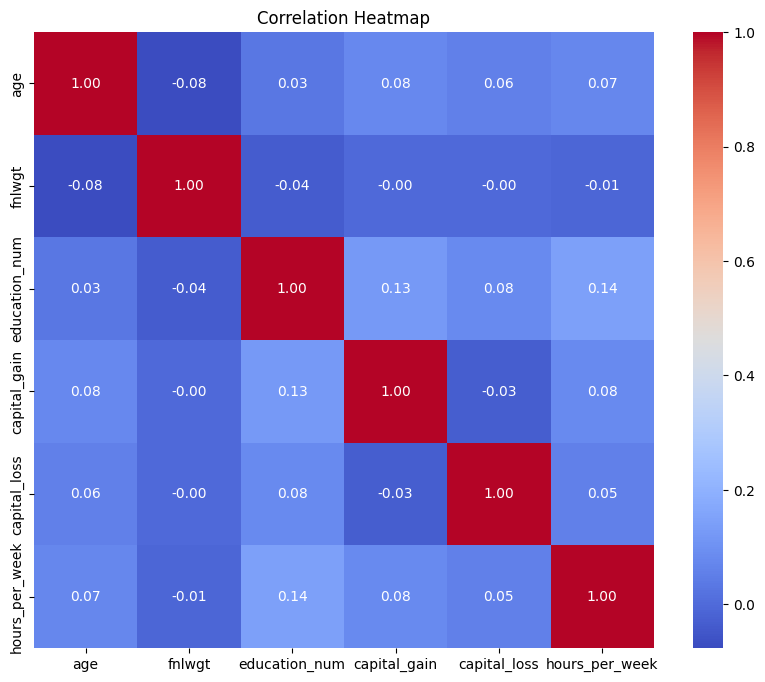

In [4]:
# ======================================================
# 步骤 3: 探索性数据分析 (EDA) - 智能识别版
# ======================================================

# [重点] 检查配置开关
if config_data['flags']['perform_eda']:
    print("📊 [Config Check] perform_eda=True，正在执行可视化分析...")
    
    # --- [修正] 智能锁定目标列 ---
    target_col = None
    
    # 1. 尝试常见名字
    if 'income' in df.columns:
        target_col = 'income'
    elif 'target' in df.columns:
        target_col = 'target'
    elif 'class' in df.columns:
        target_col = 'class'
        
    # 2. [兜底策略] 如果都找不到，默认使用最后一列
    if target_col is None:
        target_col = df.columns[-1]
        print(f"⚠️ 警告: 未找到标准目标列名，自动选择最后一列作为目标: '{target_col}'")
    else:
        print(f"✅ 锁定目标列: '{target_col}'")
        
    # 3. 统一重命名为 'target' (方便后续代码)
    if target_col != 'target':
        df.rename(columns={target_col: 'target'}, inplace=True)
        print(f"ℹ️ 已将列 '{target_col}' 重命名为 'target'。")

    # --- 开始画图 ---
    # 1. 目标变量分布
    plt.figure(figsize=(6, 4))
    # 此时列名肯定叫 'target' 了
    sns.countplot(x='target', data=df, palette='viridis')
    plt.title('Distribution of Target Variable')
    plt.show() 
    
    # 2. 数值特征相关性
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap')
        plt.show()
    else:
        print("ℹ️ 没有数值特征，跳过相关矩阵。")
        
else:
    print("⏩ [Config Check] perform_eda=False，跳过可视化分析步骤。")

In [5]:
# ======================================================
# 步骤 4: 数据清洗与特征工程
# ======================================================
from sklearn import preprocessing

df_clean = df.copy()

# 1. [可控] 删除重复值
if config_data['flags']['drop_duplicates']:
    original_len = len(df_clean)
    df_clean.drop_duplicates(inplace=True)
    print(f"🧹 已删除重复行: {original_len - len(df_clean)} 条")

# 2. [可控] 高级特征处理 (婚姻状况合并)
if config_data['flags']['use_advanced_features']:
    print("🛠️ 执行高级特征工程: 合并 Marital Status...")
    dataset_col_names = df_clean.columns
    # 寻找列名 (兼容下划线或横杠)
    marital_col = next((col for col in ['marital-status', 'marital_status'] if col in dataset_col_names), None)
    
    if marital_col:
        replacements = {
            'Divorced': 'divorced', 'Married-AF-spouse': 'married', 
            'Married-civ-spouse': 'married', 'Married-spouse-absent': 'married',
            'Never-married': 'not married', 'Separated': 'not married', 
            'Widowed': 'not married'
        }
        df_clean[marital_col] = df_clean[marital_col].astype(str).str.strip().replace(replacements)

# 3. Label Encoding (并将映射关系保存，以便查看)
le = preprocessing.LabelEncoder()
cat_cols = df_clean.select_dtypes(include=['object']).columns
encoding_maps = {}

# [修正] 在保存之前，清理列名（去掉特殊字符）
for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col])
    # 保存映射关系：{0: 'Female', 1: 'Male'}
    # 清理列名：替换掉特殊字符
    clean_col_name = col.replace('.', '_').replace('[', '_').replace(']', '_')
    
    # 注意：LabelEncoder 的 classes_ 类型可能是 numpy 类型，需要转为原生 Python 类型才能序列化
    # 比如 zip(le.classes_, le.transform(le.classes_)) 生成的是 numpy int64，这也可能导致序列化错误
    # 所以我们把它们都转成 str 或 int
    mapping = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}
    
    encoding_maps[clean_col_name] = mapping

# 上传编码字典作为 Artifact（而不是连接到配置区）
# 这样更安全，不会因为字符问题报错，而且查看也很方便
task.upload_artifact('Encoding_Mappings', artifact_object=encoding_maps)
print("✅ 特征工程完成，编码字典已作为 Artifact 上传。")

🧹 已删除重复行: 52 条
🛠️ 执行高级特征工程: 合并 Marital Status...
✅ 特征工程完成，编码字典已作为 Artifact 上传。


In [6]:
# ======================================================
# 步骤 5: 数据集划分与版本发布 (Dataset Versioning)
# ======================================================
from sklearn.model_selection import train_test_split
import os

# 1. 准备数据
target_col = 'target'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

# 2. 划分数据集
params = config_data['dataset_params']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=params['test_size'], 
    random_state=params['random_state'],
    stratify=y if params['stratify'] else None
)

print(f"✂️ 数据划分完成: Train={X_train.shape}, Test={X_test.shape}")

# 3. 保存切片到本地 (为了创建 Dataset)
os.makedirs("data_output", exist_ok=True)
X_train.to_csv("data_output/X_train.csv", index=False)
X_test.to_csv("data_output/X_test.csv", index=False)
y_train.to_csv("data_output/y_train.csv", index=False)
y_test.to_csv("data_output/y_test.csv", index=False)

# ----  Создать и загрузить ClearML Dataset ----
if config_data['flags']['upload_as_dataset']:
    print("📦 正在创建 ClearML Dataset 版本...")
    
    #Создать объект набора данных
    dataset = Dataset.create(
        dataset_project="Adult-Income-Classification", # Проект, к которому принадлежит набор данных
        dataset_name="Processed_Adult_Data"            # Название набора данных
    )
    
    # Добавить файл (добавьте только что сохраненный CSV)
    dataset.add_files("data_output/")
    
    # Загрузить и завершить (Finalize создаст неизменяемый ID)
    dataset.upload()
    dataset.finalize()
    
    print(f"✅ Dataset 版本已发布! ID: {dataset.id}")
    
    #  Мы записываем этот Dataset ID в артефакт текущей задачи
    # Таким образом, для этой обучающей задачи достаточно прочитать этот ID, чтобы найти данные
    task.upload_artifact("dataset_metadata", {"dataset_id": dataset.id})

# [Необязательно] Одновременно загрузить артефакты (для совместимости со старыми привычками и удобного просмотра)
task.upload_artifact("X_train", X_train)
task.upload_artifact("y_train", y_train)
task.upload_artifact("X_test", X_test)
task.upload_artifact("y_test", y_test)

print("🎉 Data Preparation 任务全部完成！请关闭此任务。")
task.close()

✂️ 数据划分完成: Train=(39032, 14), Test=(9758, 14)
📦 正在创建 ClearML Dataset 版本...
2025-12-26 18:31:00,405 - clearml.storage - INFO - Uploading: 5.50MB from e:/2025-2026/Git/Курсовая работа/adults.csv


██████████████████████████████████ 100% | 5.50/5.5 MB [00:02<00:00,  2.74MB/s]: 


ClearML results page: https://app.clear.ml/projects/8bafd625eee64d559dad8f1f6d807e19/experiments/17bef112a6974ba5b5ce85246b46ed19/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/8bafd625eee64d559dad8f1f6d807e19/experiments/17bef112a6974ba5b5ce85246b46ed19
Generating SHA2 hash for 4 files


100%|██████████| 4/4 [00:00<00:00, 230.23it/s]

Hash generation completed


Uploading dataset changes (4 files compressed to 899.29 KiB) to https://files.clear.ml
File compression and upload completed: total size 899.29 KiB, 1 chunk(s) stored (average size 899.29 KiB)
✅ Dataset 版本已发布! ID: 17bef112a6974ba5b5ce85246b46ed19
🎉 Data Preparation 任务全部完成！请关闭此任务。


In [8]:
# ======================================================
# Шаг 5.5: （Дополнительный）Создание альтернативной версии датасета (V2 - Median Imputation)
# Этап, необходимый для демонстрации версионирования данных 
# ======================================================

# Проверяем флаг, чтобы не делать лишнюю работу, если загрузка не нужна
if config_data['flags']['upload_as_dataset']:
    print("\n🔄 Начало создания версии V2 (заполнение пропусков медианой)...")

    # [ИСПРАВЛЕНИЕ] Получаем правильный путь из конфига (как в Шаге 1)
    # В вашем коде параметр называется 'dataset_url' внутри 'dataset_params'
    dataset_path = config_data['dataset_params']['dataset_url']

    # 1. Повторная загрузка исходных данных (чтобы начать с чистого листа)
    print(f"   📖 Чтение файла из: {dataset_path}")
    df_v2 = pd.read_csv(dataset_path)
    
    # [ИСПРАВЛЕНИЕ] Очистка имен колонок (как в Шаге 2), иначе 'target' может не найтись
    df_v2.columns = df_v2.columns.str.strip()

    # 2. Предобработка для V2 (отличается от V1 методом заполнения)
    # Удаляем дубликаты
    df_v2 = df_v2.drop_duplicates()
    
    # 智能识别 target 列 (Copy logic from Step 3 to be safe)
    target_col = None
    if 'income' in df_v2.columns: target_col = 'income'
    elif 'target' in df_v2.columns: target_col = 'target'
    elif 'class' in df_v2.columns: target_col = 'class'
    else: target_col = df_v2.columns[-1]
    
    if target_col != 'target':
        df_v2.rename(columns={target_col: 'target'}, inplace=True)

    # Кодируем категориальные признаки (как в V1)
    # Импортируем LabelEncoder если он еще не импортирован
    from sklearn.preprocessing import LabelEncoder 
    
    label_encoders_v2 = {}
    for col in df_v2.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_v2[col] = le.fit_transform(df_v2[col])
        label_encoders_v2[col] = le
    
    # --- КЛЮЧЕВОЕ ОТЛИЧИЕ V2: Заполнение пропусков МЕДИАНОЙ ---
    # В V1 мы использовали mean() (или dropna), здесь используем median()
    for col in df_v2.columns:
        if df_v2[col].isnull().any():
            median_val = df_v2[col].median()
            df_v2[col].fillna(median_val, inplace=True)
            print(f"   (V2) Колонка '{col}': пропуски заполнены медианой ({median_val})")

    # 3. Разделение на X и y
    X_v2 = df_v2.drop(columns=['target'])
    y_v2 = df_v2['target']

    # 4. Разделение на train/test (используем те же параметры для честности сравнения)
    # Импортируем train_test_split если нужно
    from sklearn.model_selection import train_test_split
    
    X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
        X_v2, y_v2, 
        test_size=config_data['dataset_params']['test_size'], 
        random_state=config_data['dataset_params']['random_state'],
        stratify=y_v2 if config_data['dataset_params']['stratify'] else None
    )

    # 5. Сохранение во временную папку (отдельную от V1)
    import os
    os.makedirs("data_output_v2", exist_ok=True)
    X_train_v2.to_csv("data_output_v2/X_train.csv", index=False)
    X_test_v2.to_csv("data_output_v2/X_test.csv", index=False)
    y_train_v2.to_csv("data_output_v2/y_train.csv", index=False)
    y_test_v2.to_csv("data_output_v2/y_test.csv", index=False)

    # 6. Создание и загрузка Dataset V2 в ClearML
    print("📦 Создание ClearML Dataset V2...")
    
    # Получаем ID родительского датасета (если V1 был создан в шаге 5)
    parent_id = dataset.id if 'dataset' in locals() else None

    dataset_v2 = Dataset.create(
        dataset_project="Adult-Income-Classification",
        dataset_name="Processed_Adult_Data_v2", # Обратите внимание на имя: _v2
        parent_datasets=[parent_id] if parent_id else None
    )
    
    dataset_v2.add_files("data_output_v2/")
    dataset_v2.upload()
    dataset_v2.finalize()
    
    print(f"✅ Dataset V2 (Median) успешно опубликован! ID: {dataset_v2.id}")
    
    # Сохраняем ID версии V2 как отдельный артефакт
    task.upload_artifact("dataset_metadata_v2", {"dataset_id": dataset_v2.id, "description": "Filled with Median"})

else:
    print("⚠️ Флаг upload_as_dataset выключен. V2 не создается.")


🔄 Начало создания версии V2 (заполнение пропусков медианой)...
   📖 Чтение файла из: adults.csv
📦 Создание ClearML Dataset V2...
ClearML results page: https://app.clear.ml/projects/e70890c857f14f789b9b09946aefbfd0/experiments/d80f117b617c42de86df03587d379857/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/e70890c857f14f789b9b09946aefbfd0/experiments/d80f117b617c42de86df03587d379857
Generating SHA2 hash for 4 files


100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


Hash generation completed
Uploading dataset changes (2 files compressed to 758.25 KiB) to https://files.clear.ml
File compression and upload completed: total size 758.25 KiB, 1 chunk(s) stored (average size 758.25 KiB)
✅ Dataset V2 (Median) успешно опубликован! ID: d80f117b617c42de86df03587d379857


Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=completed)> (task=6e616d219adb4f7ba228b2c41dc98d3d, artifacts=[{'key': 'Raw_CSV', 'type': 'custom', 'uri': 'https://files.clear.ml/Adult-Income-Classification/Data_Preparation_v1.6e616d219adb4f7ba228b2c41dc98d3d/artifacts/Raw_CSV/adults.csv', 'content_size': 5765942, 'hash': 'e985f12ecd9d87cc114558fd1b748587686a608eb3f072c6bed04684a5eefa0f', 'timestamp': 1766745046, 'type_data': {'preview': 'adults.csv - 5.77 MB\n', 'content_type': 'application/vnd.ms-excel'}}, {'key': 'Encoding_Mappings', 'type': 'dict', 'uri': 'https://files.clear.ml/Adult-Income-Classification/Data_Preparation_v1.6e616d219adb4f7ba228b2c41dc98d3d/artifacts/Encoding_Mappings/Encoding_Mappings.json', 'content_size': 2871, 'hash': 'b24ce58b9f8e2f64a54e8e7ae491bd6899fd739627f36e2ca96b06227e884cc0', 'timestamp': 1766745052, 'type_data': {'preview': '{\n    "education": {\n        " 10th": 0,\n        " 11th": 1,\n   